In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
import statsmodels.api as sm



import warnings
warnings.filterwarnings('ignore')

#import wbgapi as wb

from bs4 import BeautifulSoup
import requests
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.9", "Referer": "https://www.ewg.org/tapwater/", "Connection": "keep-alive"}



In [2]:
df=pd.read_csv('world_bank.csv')

In [3]:
df.head()

,country_code,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023,YR2024,indicator_name
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
1,AFE,140.033194,153.212052,158.713093,145.043828,171.539701,162.631844,230.443499,197.343427,221.710208,...,708.291645,752.710370,714.993810,831.583367,930.177029,876.412798,815.587170,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
2,AFG,100.000000,100.000000,104.753566,166.820931,170.469730,190.486853,141.012701,96.488541,94.179066,...,662.618287,986.802030,847.546531,535.526728,427.561572,255.254747,248.022811,324.29028,NaN,Fertilizer consumption (% of fertilizer produc...
3,AFW,138.211678,51.640760,872.676507,730.920242,767.847847,1115.063062,4661.143295,997.361838,2304.857577,...,165.207609,212.782452,203.247372,208.216797,250.471825,227.652901,88.713296,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fertilizer consumption (% of fertilizer produc...


df=df.melt(id_vars=['country_code','indicator_name'], value_name='value', var_name='year')

In [4]:
import pycountry

#html=requests.get('https://www.theglobaleconomy.com/rankings/happiness/', headers=headers).content
#happy_df = pd.read_html(html)[0][['Countries', 'Happiness index, 2024']]
happy_df=pd.read_csv('happy_df.csv')

def to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

happy_df['iso3'] = happy_df['Countries'].apply(to_iso3)

fix = {
    'UK': 'GBR',
    'UA Emirates': 'ARE',
    'Bosnia & Herz.': 'BIH',
    'Domin. Rep.': 'DOM',
    'Russia': 'RUS',
    'Ivory Coast': 'CIV',
    'Turkey': 'TUR',
    'Burma': 'MMR',
    'Swaziland': 'SWZ'
}

happy_df['iso3'] = happy_df['Countries'].apply(
    lambda x: fix[x] if x in fix else (
        pycountry.countries.lookup(x).alpha_3 if isinstance(x, str) else None
    )
)

happy_df=happy_df[['iso3', 'Happiness index, 2024']]


In [16]:
indicators=df['indicator_name'].unique()


happiness_index_corr_dict={}

for i, indicator in enumerate(indicators, start=1):
    filtered=df[df['indicator_name']==indicator]
    df_long=filtered.melt(id_vars=['country_code','indicator_name'], value_name='value', var_name='year')
    grouped=df_long.groupby('country_code')['value'].mean().reset_index()
    merged=grouped.merge(happy_df, left_on='country_code', right_on='iso3')

    occurance=merged.dropna(subset=['value', 'Happiness index, 2024']).shape[0]
    corr=float(merged['value'].corr(merged['Happiness index, 2024']))

    happiness_index_corr_dict[indicator]={'corr':corr, 'occurance':occurance}

    print(f'{i}/{len(indicators)}',end='\r')


df_happiness_corr = (
    pd.DataFrame.from_dict(happiness_index_corr_dict, orient='index')
      .reset_index()
      .rename(columns={'index': 'Indicator'})
      .sort_values('corr', ascending=False)
)



1513/1513

In [17]:
most_correlated = df_happiness_corr[
    (df_happiness_corr['corr'].abs() >= 0.7) &
    (df_happiness_corr['occurance'] >= 50) 
].sort_values('corr', ascending=False)
most_correlated

,Indicator,corr,occurance
1072,"Human capital index (HCI), female, lower bound...",0.794941,125
1070,"Human capital index (HCI), female (scale 0-1)",0.794191,125
1076,"Human capital index (HCI), female, upper bound...",0.793292,125
1073,"Human capital index (HCI), male, lower bound (...",0.790233,125
1074,"Human capital index (HCI), male (scale 0-1)",0.789902,125
...,...,...,...
859,"Mortality rate, infant, male (per 1,000 live b...",-0.761305,136
858,"Mortality rate, infant (per 1,000 live births)",-0.764090,136
857,"Mortality rate, infant, female (per 1,000 live...",-0.766669,136
519,"Mortality rate, neonatal (per 1,000 live births)",-0.775938,136


In [18]:
html=requests.get('https://data.worldbank.org/indicator?tab=all',headers=headers).content
soup=BeautifulSoup(html)

category_indicator={}
for e in  soup.select('section[class="nav-item"]'):
    category=e.select_one('h3').text.strip()
    indicators=[ind.text.strip() for ind in e.select('ul li')]
    category_indicator[category]=indicators

In [19]:
for indicator in df_happiness_corr['Indicator']:
    for category, indicators in category_indicator.items():
        if indicator.strip() in indicators:
            index=df_happiness_corr.index[df_happiness_corr['Indicator'] == indicator]
            df_happiness_corr.loc[index, 'Category']=category

In [20]:
corr_df=pd.read_csv('HI Corr.csv')
corr_df.columns=['indicator', 'corr', 'occurance', 'category']
corr_df=corr_df[['indicator', 'category', 'corr', 'occurance']]

corr_df

,indicator,category,corr,occurance
0,"Net official flows from UN agencies, UNRWA (cu...",Aid Effectiveness,1.000000,2
1,"Survey mean consumption or income per capita, ...",Poverty,0.771471,112
2,Individuals using the Internet (% of population),Infrastructure,0.765524,137
3,"Life expectancy at birth, female (years)",Social Development,0.758725,137
4,"Life expectancy at birth, total (years)",Health,0.758024,137
...,...,...,...,...
1508,"Prevalence of stunting, height for age, male (...",Health,-0.696456,115
1509,Prosperity gap (average shortfall from a prosp...,Poverty,-0.710145,128
1510,"Net official flows from UN agencies, UNCTAD (c...",Aid Effectiveness,-1.000000,2
1511,Other people in need of international protecti...,Social Protection & Labor,NaN,1


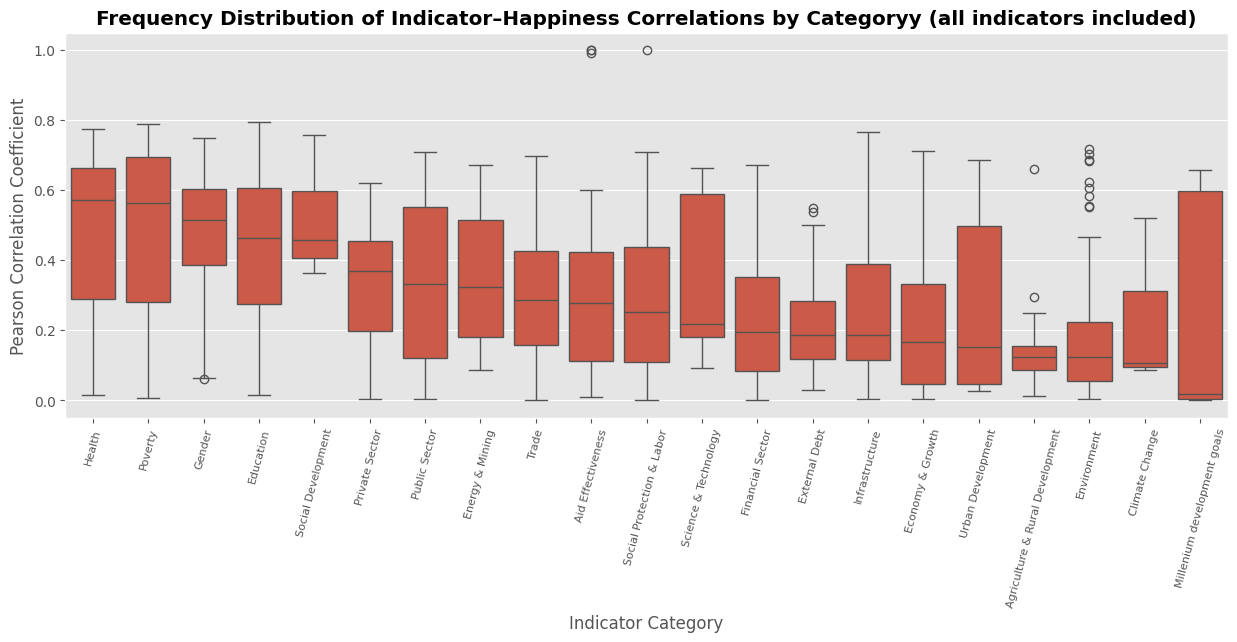

In [22]:
grouped=corr_df.groupby('category')['corr'].apply(lambda x:x.abs().median()).sort_values(ascending=False)
order =grouped.index

plt.figure(figsize=(15,5))
sns.boxplot(
    corr_df.assign(corr_abs=corr_df['corr'].abs()),
    x='category',
    y='corr_abs',
    order=order
)
plt.xticks(rotation=75, size=8)
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Indicator Category')
plt.title('Frequency Distribution of Indicator–Happiness Correlations by Categoryy (all indicators included)', fontweight='bold')
plt.show()

In [23]:
corr_df=corr_df[
    (corr_df['occurance'] >= 50) &
    (corr_df['corr'].abs() >= 0.7)
]


In [24]:
corr_df.groupby('category')['corr'].apply(lambda x:x.abs().median()).sort_values(ascending=False)

category
Education                    0.781909
Poverty                      0.756917
Social Development           0.752257
Gender                       0.731020
Infrastructure               0.723575
Health                       0.721346
Economy & Growth             0.711086
Environment                  0.710843
Public Sector                0.708124
Social Protection & Labor    0.707663
Name: corr, dtype: float64

In [25]:
df=df[df['indicator_name'].isin(corr_df['indicator'].unique().tolist())]
df['value']=df.filter(like='YR').mean(axis=1)
df=df[['country_code', 'indicator_name', 'value']]


In [26]:
merged=df.merge(happy_df, left_on='country_code', right_on='iso3')[['country_code', 'indicator_name', 'value','Happiness index, 2024']]

In [27]:
df_wide = merged.pivot(index=['country_code', 'Happiness index, 2024'], 
                   columns='indicator_name', 
                   values='value').reset_index()

Condition Number: 6.60
                              OLS Regression Results                             
Dep. Variable:     Happiness index, 2024   R-squared:                       0.649
Model:                               OLS   Adj. R-squared:                  0.640
Method:                    Least Squares   F-statistic:                     80.57
Date:                   Sat, 17 Jan 2026   Prob (F-statistic):           1.34e-29
Time:                           11:39:06   Log-Likelihood:                -140.08
No. Observations:                    135   AIC:                             288.2
Df Residuals:                        131   BIC:                             299.8
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

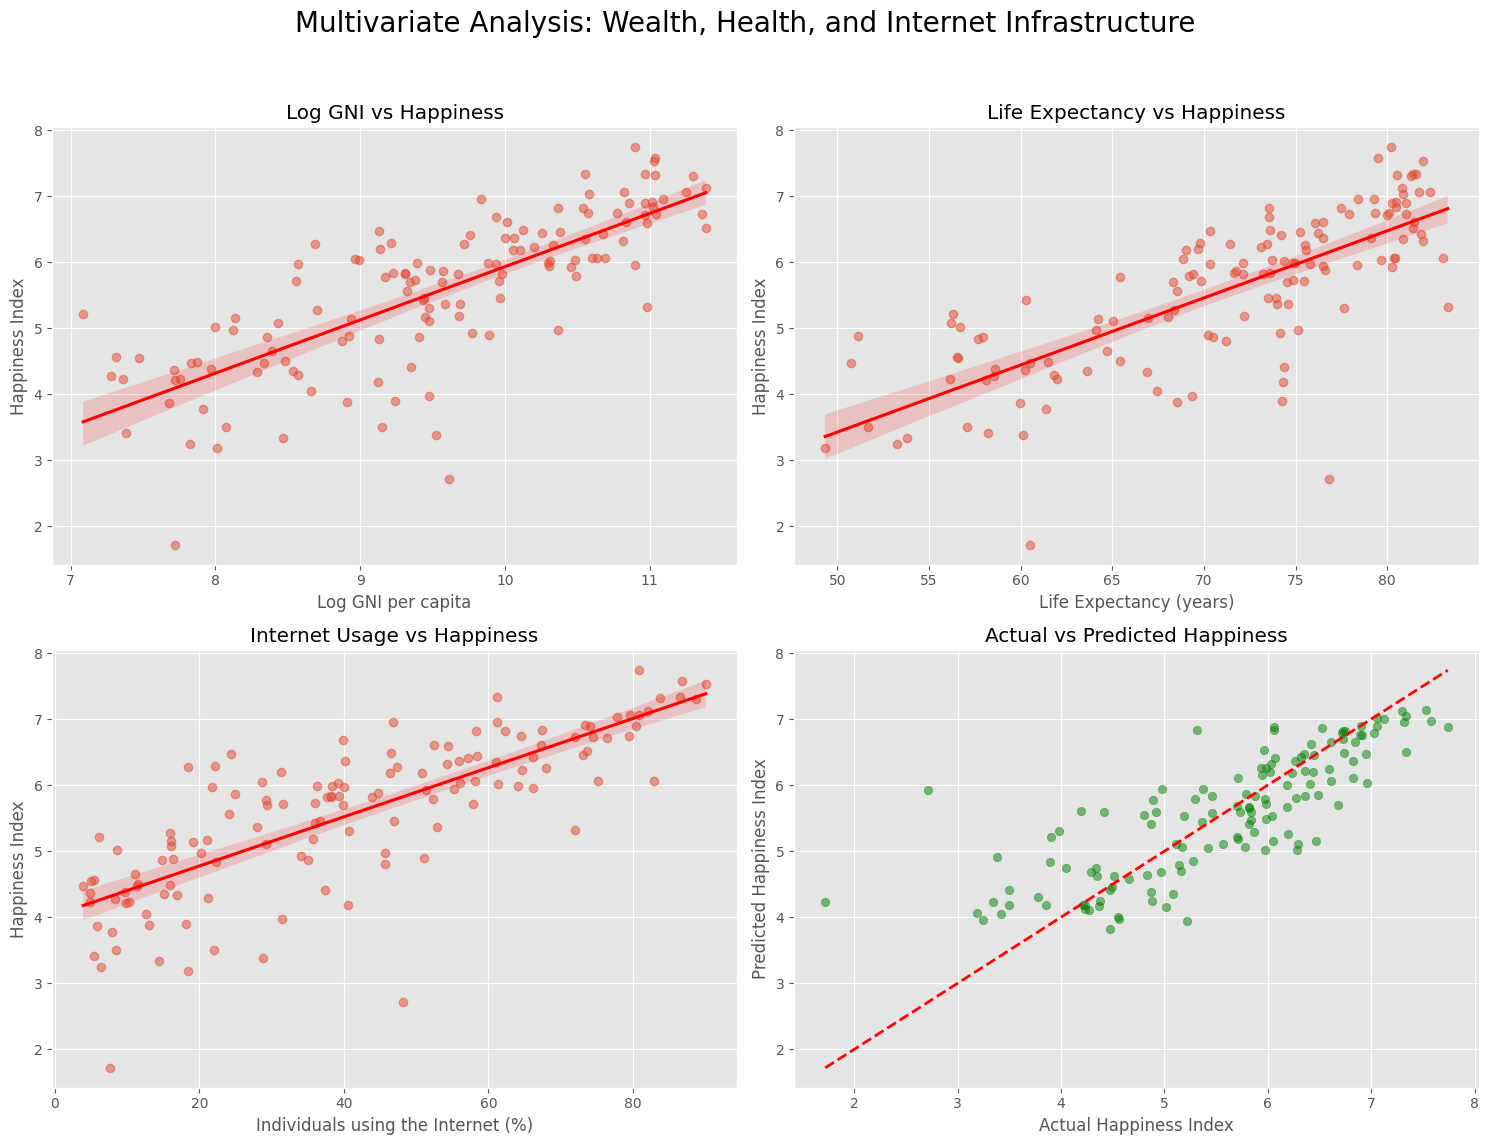

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Prepare Data
df = pd.read_csv('df_wide.csv')
df['Log_GNI'] = np.log(df['GNI per capita, PPP (constant 2021 international $)'])

target = 'Happiness index, 2024'
features = [
    'Log_GNI', 
    'Life expectancy at birth, total (years)', 
    'Individuals using the Internet (% of population)'
]

# 2. Clean
data = df[features + [target]].dropna()

# 3. STANDARDIZE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])
X_final = pd.DataFrame(X_scaled, columns=features, index=data.index)
X_final_const = sm.add_constant(X_final)

# 4. Run Model
model = sm.OLS(data[target], X_final_const).fit()

# 5. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Multivariate Analysis: Wealth, Health, and Internet Infrastructure', fontsize=20)

# Scatter 1: Log GNI (Wealth)
sns.regplot(x=data['Log_GNI'], y=data[target], ax=axes[0, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title('Log GNI vs Happiness')
axes[0, 0].set_xlabel('Log GNI per capita')
axes[0, 0].set_ylabel('Happiness Index')

# Scatter 2: Life Expectancy (Health)
sns.regplot(x=data[features[1]], y=data[target], ax=axes[0, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title('Life Expectancy vs Happiness')
axes[0, 1].set_xlabel('Life Expectancy (years)')
axes[0, 1].set_ylabel('Happiness Index')

# Scatter 3: Internet Usage (Infrastructure)
sns.regplot(x=data[features[2]], y=data[target], ax=axes[1, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 0].set_title('Internet Usage vs Happiness')
axes[1, 0].set_xlabel('Individuals using the Internet (%)')
axes[1, 0].set_ylabel('Happiness Index')

# Scatter 4: Actual vs Predicted
predictions = model.predict(X_final_const)
axes[1, 1].scatter(data[target], predictions, alpha=0.5, color='green')
axes[1, 1].plot([data[target].min(), data[target].max()], [data[target].min(), data[target].max()], 'r--', lw=2)
axes[1, 1].set_title('Actual vs Predicted Happiness')
axes[1, 1].set_xlabel('Actual Happiness Index')
axes[1, 1].set_ylabel('Predicted Happiness Index')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('multivariate_analysis_internet.png')

print(f"Condition Number: {model.condition_number:.2f}")
print(model.summary())

# Supporting Easterlin Paradox

In [5]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv('world_happiness_combined.csv',sep=';')

In [7]:
df=df[['Year','Country', 'Regional indicator', 'Happiness score']]

In [8]:
df['Happiness score']=df['Happiness score'].str.replace(',','.').apply(pd.to_numeric)

In [9]:
df=df.sort_values(['Country', 'Year'])

In [10]:
df

,Year,Country,Regional indicator,Happiness score
152,2015,Afghanistan,South Asia,3.5750
169,2016,Afghanistan,South Asia,3.3600
463,2017,Afghanistan,South Asia,3.7940
470,2018,Afghanistan,South Asia,3.6315
777,2019,Afghanistan,South Asia,3.2033
...,...,...,...,...
929,2020,Zimbabwe,Sub-Saharan Africa,3.2992
1079,2021,Zimbabwe,Sub-Saharan Africa,3.1448
1224,2022,Zimbabwe,Sub-Saharan Africa,2.9951
1358,2023,Zimbabwe,Sub-Saharan Africa,3.2035


In [11]:
import country_converter as coco

# Initialize the converter
cc = coco.CountryConverter()

# Convert the column
df['ISO3'] = cc.convert(names=df['Country'], to='ISO3')

Argelia not found in regex
Argelia not found in regex
Argelia not found in regex
Argelia not found in regex
Argelia not found in regex
Argelia not found in regex
Argelia not found in regex
Argelia not found in regex


In [12]:
indicators_df=pd.read_csv('world_bank.csv')

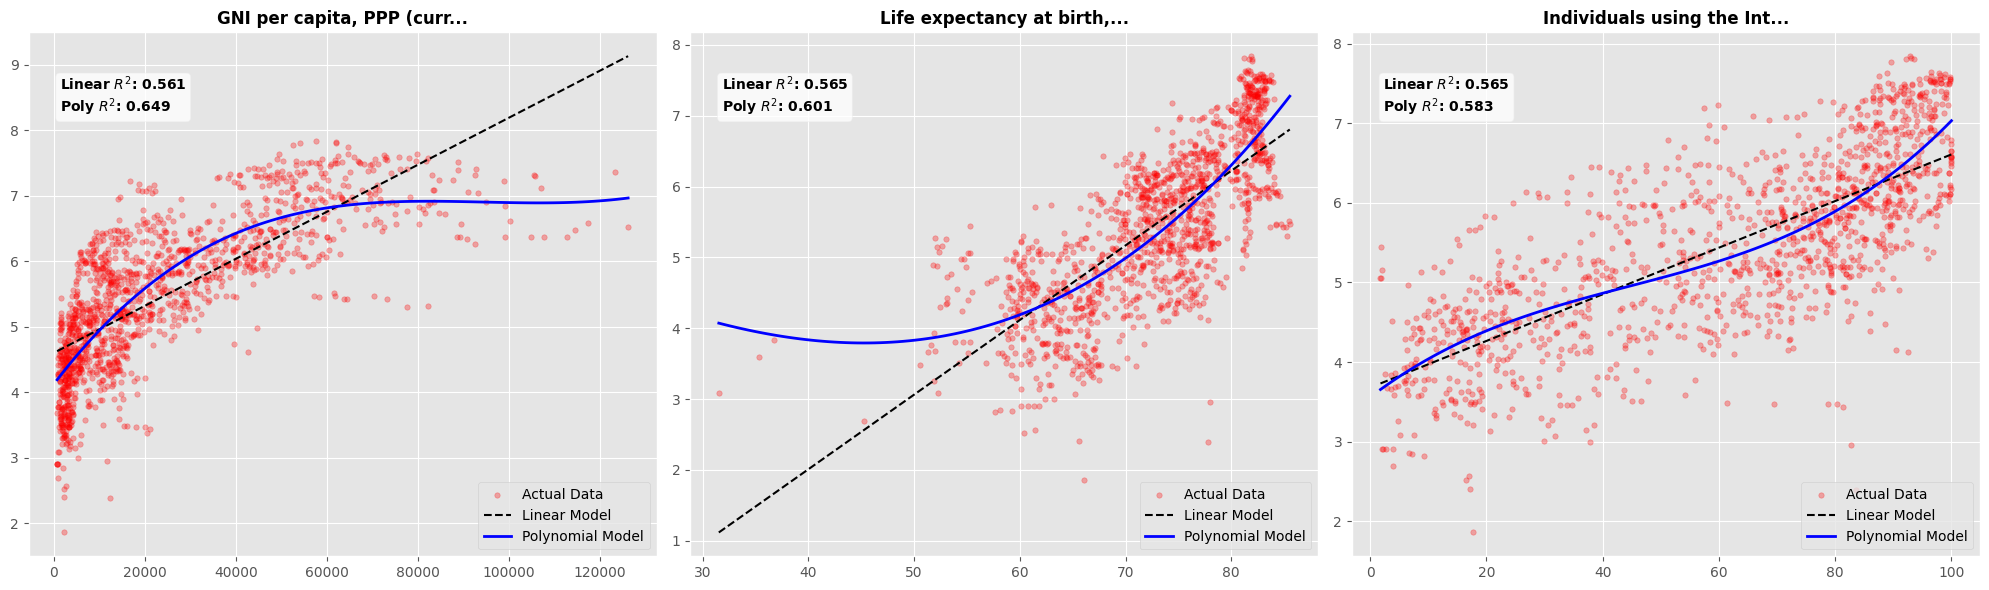

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

features = [
    'GNI per capita, PPP (current international $)', 
    'Life expectancy at birth, total (years)', 
    'Individuals using the Internet (% of population)'
]

def calculate_linearity(x, y):
    X = x.values.reshape(-1, 1)
    
    lin_reg = LinearRegression().fit(X, y)
    r2_lin = r2_score(y, lin_reg.predict(X))
    
    poly_features = PolynomialFeatures(degree=3)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y)
    r2_poly = r2_score(y, poly_reg.predict(X_poly))
    
    score = min(r2_lin / r2_poly, 1.0) if r2_poly > 0 else 0
    return r2_lin, r2_poly, score

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for feature, ax in zip(features, axes.flatten()):
    indicator_df = indicators_df[indicators_df['indicator_name'] == feature]
    melted_df = indicator_df.melt(id_vars=['country_code', 'indicator_name'], 
                                  var_name='Year', value_name='Value')
    
    melted_df['Year'] = melted_df['Year'].str.replace('YR', '').astype(int)
    
    merged = df.merge(melted_df, left_on=['ISO3', 'Year'], right_on=['country_code', 'Year'])
    merged = merged[['Happiness score', 'Value']].dropna()
    
    x = merged['Value']
    y = merged['Happiness score']

    r2_lin, r2_poly, linearity_score = calculate_linearity(x, y)

    ax.scatter(x, y, c='red', alpha=0.3, s=15, label='Actual Data')
    
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    
    lin_model = LinearRegression().fit(x.values.reshape(-1,1), y)
    ax.plot(x_range, lin_model.predict(x_range), color='black', 
            linestyle='--', label='Linear Model')
    
    poly_f = PolynomialFeatures(degree=3)
    poly_model = LinearRegression().fit(poly_f.fit_transform(x.values.reshape(-1,1)), y)
    ax.plot(x_range, poly_model.predict(poly_f.transform(x_range)), 
            color='blue', linewidth=2, label='Polynomial Model')

    ax.set_title(f"{feature[:25]}...", fontsize=12, fontweight='bold')
    
    stats_text = (
                  f'Linear $R^2$: {r2_lin:.3f}\n'
                  f'Poly $R^2$: {r2_poly:.3f}')
    
    ax.text(0.05, 0.92, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('linearities.png')
plt.show()